<center> <h1>PREDICCIÓN DEL SUEÑO</h1> </center>
<center> <h3>CREACIÓN SUBCONJUNTOS DE TRAIN Y TEST</h3> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza</h4> </center>

### Índice de contenidos de este Notebook

En este Notebook se realiza la separación del dataframe en los subgrupos de Train y Test. Como primera aproximación se ha decidido trabajar con un total de 50 ventanas por sujeto y no con todas, por cuestiones de tiempo de ejecución.

    1. Creación de los conjuntos Train y Test
    2. Preparación datos de entrada y salida

In [1]:
import os
import numpy as np
import pandas as pd
from random import sample
import statistics as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

Se carga el dataframe creado con las características extraídas de todos los sujetos:

In [2]:
df= pd.read_csv('features.csv')

In [3]:
df.sample(10)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
18522,52.0,53.0,52.83,1.00,-0.52,-0.28,-0.42,-0.28,-0.01,-0.11,-0.93,-0.85,-0.90,0.0,0.0,23.0
9051,50.0,56.0,52.50,0.99,-0.45,-0.43,-0.44,0.47,0.48,0.48,-0.76,-0.75,-0.75,1.0,2.0,10.0
9886,59.0,59.0,59.00,1.00,-0.47,-0.44,-0.45,-0.76,-0.70,-0.73,0.44,0.56,0.51,0.0,5.0,11.0
16572,72.0,77.0,73.60,1.00,0.09,0.10,0.09,0.17,0.18,0.18,-0.98,-0.97,-0.98,0.0,0.0,21.0
11974,64.0,71.0,67.00,0.99,-0.34,-0.34,-0.34,0.04,0.05,0.05,-0.94,-0.93,-0.93,0.0,5.0,14.0
15452,58.0,70.0,63.80,0.99,-0.55,-0.00,-0.21,0.18,1.10,0.67,-1.06,-0.13,-0.61,1.0,1.0,18.0
14976,59.0,60.0,59.67,1.00,-0.09,-0.08,-0.08,0.20,0.21,0.21,0.98,0.98,0.98,1.0,2.0,17.0
18719,58.0,59.0,58.83,1.00,-0.48,-0.46,-0.47,-0.57,-0.56,-0.56,-0.68,-0.67,-0.67,1.0,3.0,23.0
3209,54.0,55.0,54.50,1.00,-0.27,-0.26,-0.26,0.30,0.30,0.30,-0.93,-0.92,-0.92,1.0,2.0,3.0
2645,57.0,62.0,58.86,1.01,-0.76,0.92,0.17,-0.09,1.14,0.59,-0.94,0.27,-0.59,0.0,0.0,3.0


## 1. Creación de los conjuntos Train y Test

Se crean 2 listas aleatorias con una **proporción de 3:1** para Train y Test.

In [4]:
lista = list(range(31)) # Lista de 31 números
suj_train = sample(lista,k=24) # 21 sujetos de train
suj_test = [el for el in lista if el not in suj_train] #Los que no están en train van a test (7)

print(len(suj_train),'sujetos de train:',suj_train)
print(len(suj_test),'sujetos de test:',suj_test)

24 sujetos de train: [20, 15, 2, 5, 1, 13, 30, 22, 7, 28, 11, 25, 4, 26, 17, 14, 21, 12, 6, 16, 3, 8, 23, 27]
7 sujetos de test: [0, 9, 10, 18, 19, 24, 29]


Con cada una de las listas de sujetos anteriores, se crean los conjuntos de Train y Test de manera que no se mezclen los sujetos entre cada uno de los dos subconjuntos:

In [5]:
train_matr = []
test_matr = []
id = df['ID']

for i in suj_train:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    train_matr.append(m)

for i in suj_test:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    test_matr.append(m)

En este caso, los conjuntos de Train y Test se han creado con **50 ventanas** deslizantes y no con todas.

In [83]:
lista_ventanas=list(np.linspace(0,0.99,50)) #[0,1/10,1/5,3/10,4/10,5/10,6/10,7/10,8/10,9/10]

Train = pd.DataFrame()  
for i in range(len(train_matr)):
    lista_multi=[int(element * len(train_matr[i])) for element in lista_ventanas]
    ven1=train_matr[i].iloc[lista_multi]
    Train=Train.append(ven1)

Test = pd.DataFrame()  
for i in range(len(test_matr)):
    lista_multi=[int(element * len(test_matr[i])) for element in lista_ventanas]
    ven2=test_matr[i].iloc[lista_multi]
    Test=Test.append(ven2)

### 2.Normalización de los datos

In [84]:
Train_tt=Train.copy()
Test_tt=Test.copy()

In [85]:
Etiquetas = Train[['Etiquetas binarias','Etiquetas multiclase','ID']]

In [86]:
X_train=Train_tt.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
columns_name=list(X_train.columns)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
Train_transformed=pd.DataFrame(X_train_transformed, columns=columns_name)
Train_transformed['Etiquetas multiclase'], Train_transformed['Etiquetas binarias'], Train_transformed['ID'] = [Train['Etiquetas multiclase'].values, Train['Etiquetas binarias'].values, Train['ID'].values]

X_test=Test_tt.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
scaler = preprocessing.StandardScaler().fit(X_train)
X_test_transformed = scaler.transform(X_test)
Test_transformed=pd.DataFrame(X_test_transformed, columns=columns_name)
Test_transformed['Etiquetas multiclase'], Test_transformed['Etiquetas binarias'], Test_transformed['ID'] = [Test['Etiquetas multiclase'].values, Test['Etiquetas binarias'].values, Test['ID'].values]

In [87]:
#Train_transformed

In [88]:
#Train

In [89]:
#Test.sample(10)

In [90]:
Train.to_csv('Train.csv', header=True, index=False)
Test.to_csv('Test.csv', header=True, index=False)
Train_transformed.to_csv('Train_transformed.csv', header=True, index=False)
Test_transformed.to_csv('Test_transformed.csv', header=True, index=False)

COMPARAR LOS DOS SUBCONJUNTOS

HISTOGRAMA DATOS TRAIN


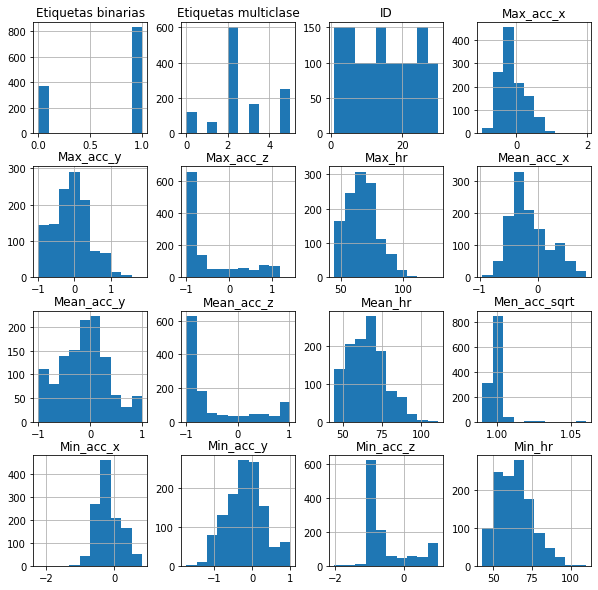

In [91]:
print(chr(27)+"[1;34m"+'HISTOGRAMA DATOS TRAIN')
Train.hist(figsize=(10, 10))
plt.show()

In [92]:
Train.describe()

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,63.943333,67.530000,65.655850,0.997875,-0.172625,-0.109125,-0.138383,-0.170742,-0.072092,-0.119358,-0.511367,-0.425400,-0.471683,0.690833,2.515833,14.833333
std,11.072968,12.336569,11.478986,0.005409,0.359592,0.355711,0.335839,0.476427,0.488688,0.457205,0.644706,0.660223,0.640535,0.462343,1.486581,8.880950
min,43.000000,45.000000,44.800000,0.990000,-2.230000,-0.940000,-0.950000,-1.720000,-0.990000,-1.000000,-2.020000,-1.000000,-1.000000,0.000000,0.000000,1.000000
25%,55.000000,58.000000,56.330000,0.990000,-0.410000,-0.360000,-0.380000,-0.492500,-0.412500,-0.440000,-0.930000,-0.900000,-0.910000,0.000000,2.000000,6.750000
50%,64.000000,67.000000,65.330000,1.000000,-0.245000,-0.190000,-0.220000,-0.150000,-0.085000,-0.120000,-0.830000,-0.780000,-0.810000,1.000000,2.000000,14.500000
75%,70.000000,75.000000,72.872500,1.000000,0.022500,0.080000,0.050000,0.140000,0.220000,0.170000,-0.240000,0.000000,-0.127500,1.000000,3.000000,22.250000
max,110.000000,128.000000,110.830000,1.060000,0.820000,1.960000,0.830000,0.990000,1.850000,0.990000,1.000000,1.410000,1.010000,1.000000,5.000000,30.000000


HISTOGRAMA DATOS TEST


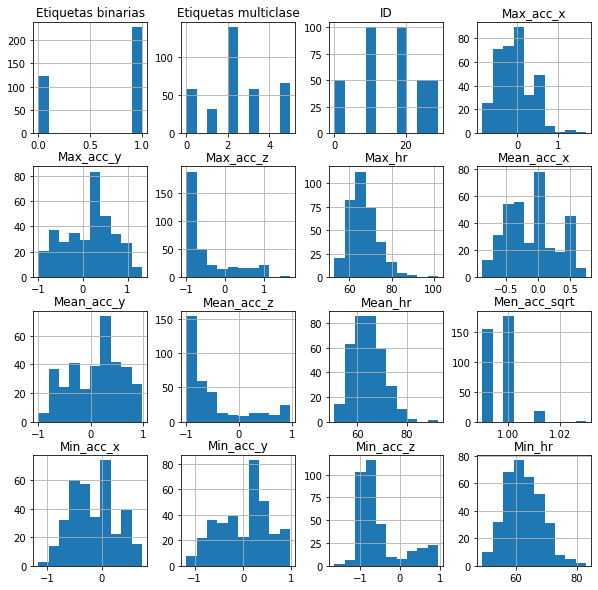

In [93]:
print(chr(27)+"[1;34m"+'HISTOGRAMA DATOS TEST')
Test.hist(figsize=(10, 10))
plt.show()

In [94]:
Test.describe()

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,62.582857,66.482857,64.393914,0.996171,-0.138171,-0.052971,-0.098886,0.031800,0.138371,0.092686,-0.529486,-0.427571,-0.485943,0.648571,2.317143,15.571429
std,5.972501,6.917317,6.071964,0.006120,0.411985,0.422662,0.387004,0.513517,0.530792,0.498960,0.578478,0.617568,0.573026,0.478100,1.584124,9.160416
min,49.000000,53.000000,50.830000,0.990000,-1.160000,-0.860000,-0.860000,-1.170000,-0.990000,-1.000000,-1.640000,-0.990000,-0.990000,0.000000,0.000000,0.000000
25%,59.000000,62.000000,60.000000,0.990000,-0.497500,-0.400000,-0.420000,-0.360000,-0.280000,-0.325000,-0.900000,-0.865000,-0.877500,0.000000,1.250000,9.000000
50%,62.000000,65.000000,63.690000,1.000000,-0.170000,-0.030000,-0.140000,0.155000,0.220000,0.200000,-0.795000,-0.740000,-0.775000,1.000000,2.000000,18.000000
75%,67.000000,71.000000,68.957500,1.000000,0.115000,0.177500,0.130000,0.397500,0.480000,0.430000,-0.442500,-0.180000,-0.380000,1.000000,3.000000,24.000000
max,83.000000,102.000000,92.500000,1.030000,0.740000,1.700000,0.750000,0.970000,1.320000,0.970000,0.960000,1.680000,0.960000,1.000000,5.000000,29.000000


1.0    829
0.0    371
Name: Etiquetas binarias, dtype: int64
1.0    227
0.0    123
Name: Etiquetas binarias, dtype: int64


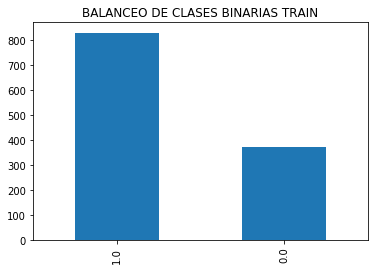

<Figure size 432x288 with 0 Axes>

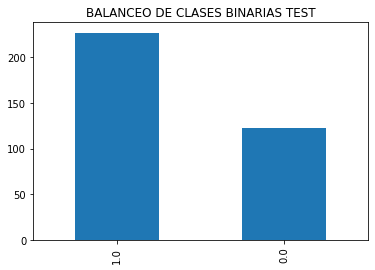

In [95]:
Train['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TRAIN")
plt.figure()
print(Train["Etiquetas binarias"].value_counts() )

#Test['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TEST")
plt.figure()
Test['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TEST")
print(Test["Etiquetas binarias"].value_counts() )

2.0    599
5.0    251
3.0    168
0.0    120
1.0     62
Name: Etiquetas multiclase, dtype: int64
2.0    138
5.0     66
3.0     58
0.0     57
1.0     31
Name: Etiquetas multiclase, dtype: int64


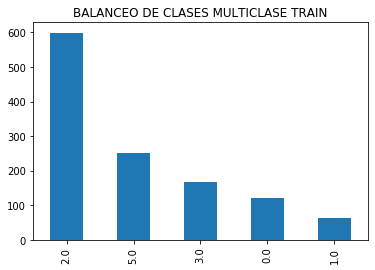

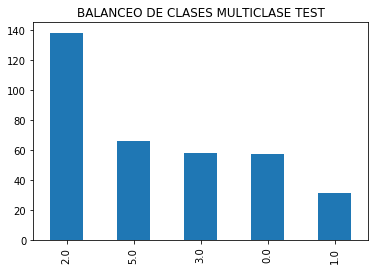

<Figure size 432x288 with 0 Axes>

In [96]:
Train['Etiquetas multiclase'].value_counts().plot.bar(title="BALANCEO DE CLASES MULTICLASE TRAIN")
plt.figure()
print(Train["Etiquetas multiclase"].value_counts() )

Test['Etiquetas multiclase'].value_counts().plot.bar(title="BALANCEO DE CLASES MULTICLASE TEST")
plt.figure()
print(Test["Etiquetas multiclase"].value_counts() )